# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [5]:
import numpy as np
import torch
import cv2

In [6]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.0.1+cu118
CUDA version: 11.8
cuDNN version: 8700


In [7]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

Helper code for making plots:

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=False):
#     fig, ax = plt.subplots(1, figsize=(10, 10))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
#     ax1.grid(False)
    ax1.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        print(ymin, xmin, ymax, xmax)
        ax1.add_patch(rect)
        
        ymin = ymin.clip(min=0)
        xmin = xmin.clip(min=0)
        ymax = ymax.clip(min=0)
        xmax = xmax.clip(min=0)
        
        crop = img[ int(ymin):int(ymax), int(xmin):int(xmax)]
        ax2.imshow(crop)
#         rows = 2
#         columns = 2
#         fig.add_subplot(rows, columns, 1) 

#         # showing image 
#         ax.imshow(img) 
#         ax.add_patch(rect)

#         # Adds a subplot at the 2nd position 
#         fig.add_subplot(rows, columns, 2) 

#         # showing image 
#         ax.imshow(crop) 
#         plt.imshow(crop)
#         plt.show()
    
        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

## Load the front and back models

In [16]:
from blazeface import BlazeFace

front_net = BlazeFace().to(gpu)
front_net.load_weights("blazeface.pth")
front_net.load_anchors("anchors.npy")
back_net = BlazeFace(back_model=True).to(gpu)
back_net.load_weights("blazefaceback.pth")
back_net.load_anchors("anchorsback.npy")

# Optionally change the thresholds:
front_net.min_score_thresh = 0.75
front_net.min_suppression_threshold = 0.3

## Make a prediction

The input image should be 128x128 for the front model and 256x256 for the back model. BlazeFace will not automatically resize the image, you have to do this yourself!

In [57]:
img = cv2.imread("/usr/src/app/dasha_diploma/data5/images/0.jpg")
img = cv2.resize(img, (128, 128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [58]:
front_detections = front_net.predict_on_image(img)
front_detections.shape

torch.Size([1, 17])

In [59]:
front_detections

tensor([[-0.1172,  0.1106,  0.5247,  0.7525,  0.2770, -0.0098,  0.5983, -0.0036,
          0.4438,  0.0816,  0.4406,  0.2877,  0.0988,  0.0934,  0.7494,  0.1043,
          0.8857]], device='cuda:0')

Found 1 faces
-14.998908996582031 14.158289909362793 67.16053771972656 96.31683349609375


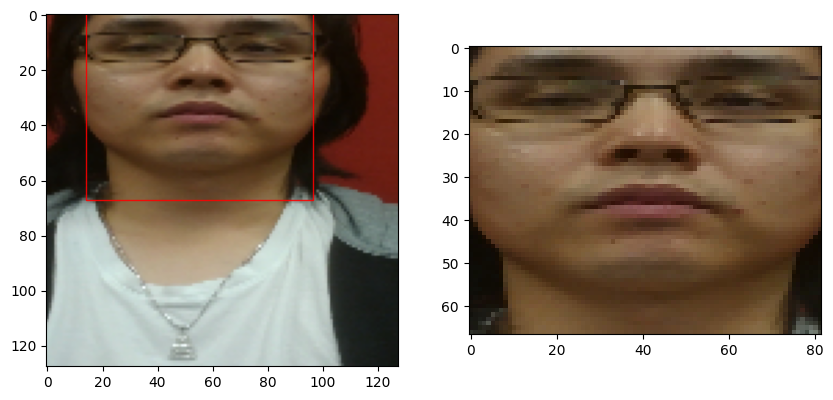

In [62]:
plot_detections(img, front_detections)

In [10]:
img2 = cv2.resize(img, (256, 256))
back_detections = back_net.predict_on_image(img2)
back_detections.shape

torch.Size([1, 17])

In [11]:
back_detections

tensor([[0.2729, 0.3162, 0.4527, 0.4960, 0.3873, 0.3154, 0.4597, 0.3212, 0.4349,
         0.3587, 0.4272, 0.3989, 0.3224, 0.3346, 0.4797, 0.3432, 0.8783]],
       device='cuda:0')

Found 1 faces


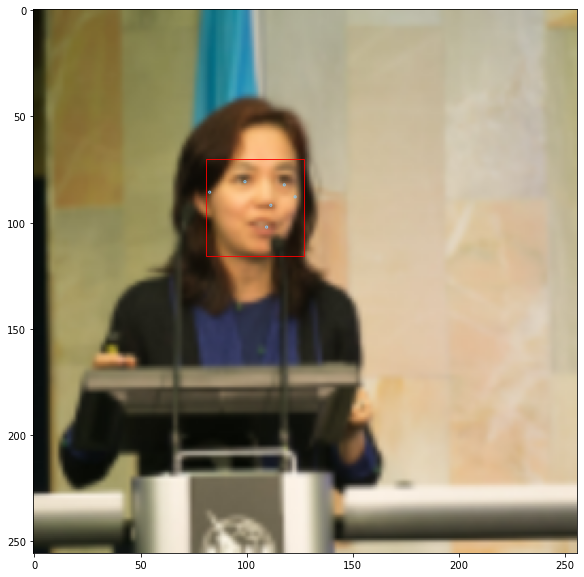

In [12]:
plot_detections(img2, back_detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)` for front model or of size `(batch, 256, 256, 3)` for back model. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)` or `(batch, 3, 256, 256)`.

In [13]:
filenames = [ "1face.png", "3faces.png", "4faces.png" ]

xfront = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)
xback = np.zeros((len(filenames), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xfront[i] = img
    xback[i] = cv2.resize(img, (256, 256))

In [15]:
front_detections = front_net.predict_on_batch(xfront)
[d.shape for d in front_detections]

[torch.Size([1, 17]), torch.Size([3, 17]), torch.Size([0, 17])]

In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!unzip /usr/src/app/dasha_diploma/Sleepy_classification.zip

Archive:  /usr/src/app/dasha_diploma/Sleepy_classification.zip
   creating: Sleepy_classification/Closed/
  inflating: Sleepy_classification/Closed/0.jpg  
  inflating: Sleepy_classification/Closed/00.jpg  
  inflating: Sleepy_classification/Closed/1.jpg  
  inflating: Sleepy_classification/Closed/10.jpg  
  inflating: Sleepy_classification/Closed/11.jpg  
  inflating: Sleepy_classification/Closed/12.jpg  
  inflating: Sleepy_classification/Closed/13.jpg  
  inflating: Sleepy_classification/Closed/14.jpg  
  inflating: Sleepy_classification/Closed/15.jpg  
  inflating: Sleepy_classification/Closed/16.jpg  
  inflating: Sleepy_classification/Closed/17.jpg  
  inflating: Sleepy_classification/Closed/18.jpg  
  inflating: Sleepy_classification/Closed/19.jpg  
  inflating: Sleepy_classification/Closed/2.jpg  
  inflating: Sleepy_classification/Closed/20.jpg  
  inflating: Sleepy_classification/Closed/21.jpg  
  inflating: Sleepy_classification/Closed/22.jpg  
  inflating: Sleepy_classifica

In [3]:
data_dir  = '/usr/src/app/dasha_diploma/BlazeFace-PyTorch/Sleepy_classification'

classes = os.listdir(data_dir)
print(classes)

['Opened', 'Closed']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [5]:
len(dataset)

9108

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: Closed (Class No: 0)


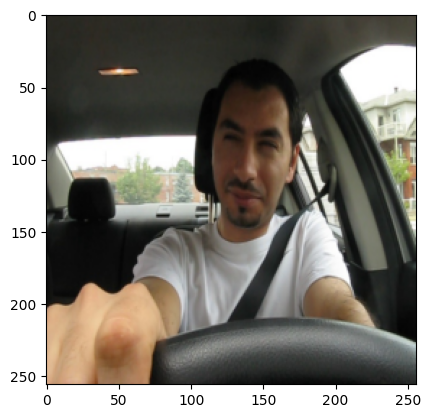

In [7]:
img, label = dataset[12]
show_sample(img, label)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [7000, 1000, 1108])
len(train_ds), len(val_ds), len(test_ds)

(7000, 1000, 1108)

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 4

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

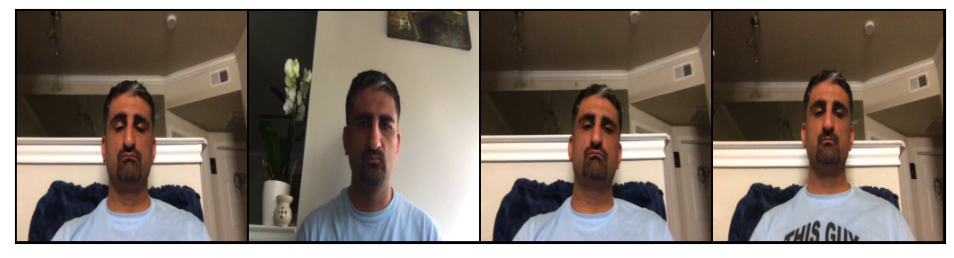

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ResNet(), device)

In [21]:
evaluate(model, val_dl)

{'val_loss': 0.6970160007476807, 'val_acc': 0.492000013589859}

In [22]:
torch.cuda.empty_cache()

In [23]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.4449, val_loss: 0.3868, val_acc: 0.9240
Epoch 2: train_loss: 0.3967, val_loss: 0.3985, val_acc: 0.9140
Epoch 3: train_loss: 0.3760, val_loss: 0.3712, val_acc: 0.9400
Epoch 4: train_loss: 0.3672, val_loss: 0.3677, val_acc: 0.9450
Epoch 5: train_loss: 0.3687, val_loss: 0.3705, val_acc: 0.9410
Epoch 6: train_loss: 0.3625, val_loss: 0.3787, val_acc: 0.9330
Epoch 7: train_loss: 0.3591, val_loss: 0.3630, val_acc: 0.9510
Epoch 8: train_loss: 0.3509, val_loss: 0.4008, val_acc: 0.9080


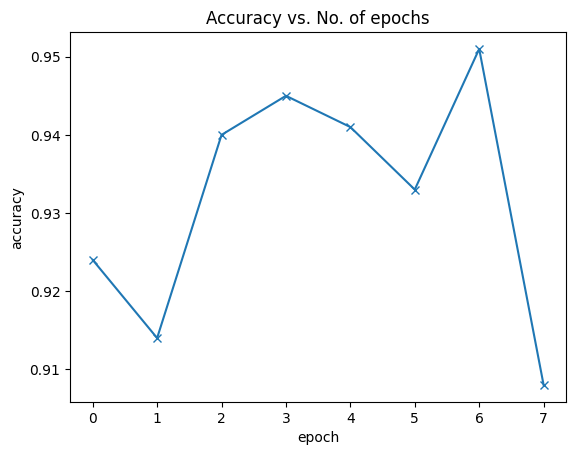

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

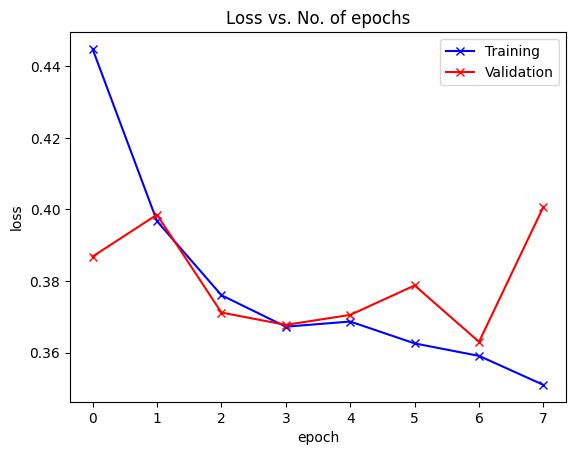

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Closed , Predicted: Closed


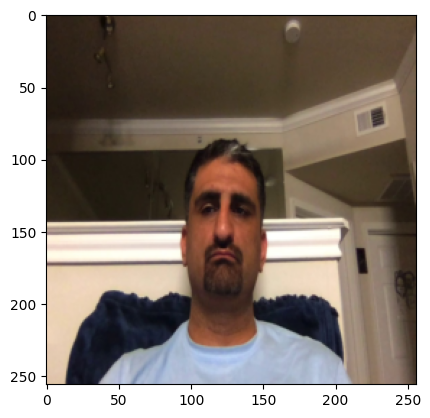

In [27]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Closed , Predicted: Closed


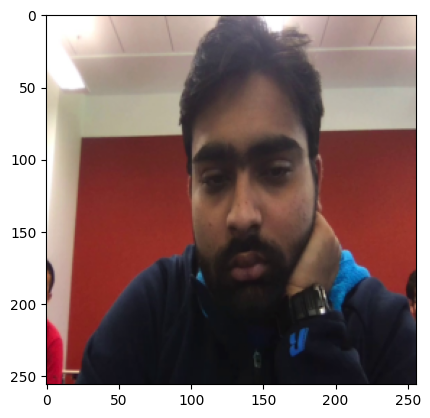

In [28]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Opened , Predicted: Opened


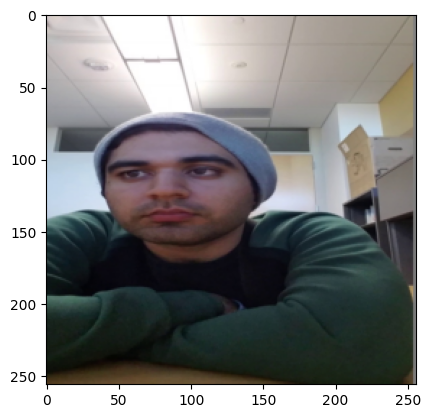

In [34]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [47]:
loaded_model = model

In [53]:
torch.save(loaded_model.state_dict(), 'model.pth')

In [44]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles Closed.


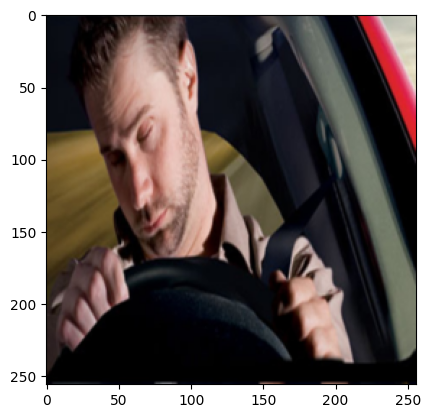

In [46]:
predict_external_image('original.jpg')